<a href="https://colab.research.google.com/github/ffatmanurggultekin/scoliosis-detection/blob/main/ResNet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define your data directories
train_dir = '/content/drive/MyDrive/train_imadjust_sobel_diff_alpha0.5'
val_dir = '/content/drive/MyDrive/validation_imadjust_sobel_diff_alpha0.5'
test_dir = '/content/drive/MyDrive/test_imadjust_sobel_diff_alpha0.5'


In [ ]:
# Combine train and validation directories for cross-validation
def gather_paths_and_labels(directory):
    data = []
    for label, class_name in enumerate(['Normal', 'Scol']):
        class_dir = os.path.join(directory, class_name)
        for file in os.listdir(class_dir):
            data.append((os.path.join(class_dir, file), label))
    return np.array(data)

train_data = gather_paths_and_labels(train_dir)
val_data = gather_paths_and_labels(val_dir)
test_data = gather_paths_and_labels(test_dir)

# Merge train and validation data for cross-validation
train_val_data = np.concatenate((train_data, val_data))


In [ ]:
# Model creation function
def create_resnet101_model():
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Cross-validation function
def run_cross_validation(data, n_splits=5, epochs=50, batch_size=32):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data[:, 0], data[:, 1])):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")
        train_files, val_files = data[train_idx], data[val_idx]

        train_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
            pd.DataFrame({'filename': train_files[:, 0], 'class': train_files[:, 1]}),
            x_col='filename', y_col='class',
            target_size=(224, 224), batch_size=batch_size, class_mode='binary', shuffle=True
        )

        val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
            pd.DataFrame({'filename': val_files[:, 0], 'class': val_files[:, 1]}),
            x_col='filename', y_col='class',
            target_size=(224, 224), batch_size=batch_size, class_mode='binary', shuffle=False
        )

        model = create_resnet101_model()
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping], verbose=1)

        val_labels = val_files[:, 1].astype(int)
        val_preds = (model.predict(val_gen) > 0.5).astype(int).ravel()

        accuracy_list.append((val_preds == val_labels).mean())
        precision_list.append(precision_score(val_labels, val_preds))
        recall_list.append(recall_score(val_labels, val_preds))
        f1_list.append(f1_score(val_labels, val_preds))

    print("\n5-Fold Cross-Validation Results:")
    print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
    print(f"Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
    print(f"Recall: {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
    print(f"F1-Score: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")

    return model



In [ ]:
# Run cross-validation
final_model = run_cross_validation(train_val_data)


=== Fold 1/5 ===
Found 171 validated image filenames belonging to 2 classes.
Found 43 validated image filenames belonging to 2 classes.
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.6450 - loss: 0.7513 - val_accuracy: 0.7209 - val_loss: 0.6450
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.5619 - loss: 0.7405 - val_accuracy: 0.7209 - val_loss: 0.6317
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7311 - loss: 0.5847 - val_accuracy: 0.7209 - val_loss: 0.5942
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6996 - loss: 0.6446 - val_accuracy: 0.7209 - val_loss: 0.5901
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.6528 - loss: 0.6504 - val_accuracy: 0.7209 - val_loss: 0.5883
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.7175 - loss: 0.6152 - val_accuracy: 0.7209 - val_loss: 0.6010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7489 - loss: 0.5482 - val_accuracy: 0.7209 - val_loss: 0.5852
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6856 - loss: 0.6128 - val_accuracy: 0.7209 - val_loss: 0.5860
Epoch 9

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5518 - loss: 0.7820 - val_accuracy: 0.7209 - val_loss: 0.5900
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.6969 - loss: 0.6331 - val_accuracy: 0.7209 - val_loss: 0.5893
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6796 - loss: 0.6286 - val_accuracy: 0.7209 - val_loss: 0.5915
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.7192 - loss: 0.6465 - val_accuracy: 0.7209 - val_loss: 0.5973
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7092 - loss: 0.6419 - val_accuracy: 0.7209 - val_loss: 0.5898
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7557 - loss: 0.5764 - val_accuracy: 0.7209 - val_loss: 0.6089
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.7393 - loss: 0.5896 - val_accuracy: 0.7209 - val_loss: 0.5859
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7541 - loss: 0.5807 - val_accuracy: 0.7209 - val_loss: 0.5865
Epoch 9

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.5706 - loss: 0.7758 - val_accuracy: 0.7209 - val_loss: 0.5896
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.7263 - loss: 0.6418 - val_accuracy: 0.7209 - val_loss: 0.5933
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.7512 - loss: 0.6042 - val_accuracy: 0.7209 - val_loss: 0.5866
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6033 - loss: 0.7615 - val_accuracy: 0.7209 - val_loss: 0.5865
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.7453 - loss: 0.6265 - val_accuracy: 0.7209 - val_loss: 0.6638
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7701 - loss: 0.5577 - val_accuracy: 0.7209 - val_loss: 0.5966
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.6750 - loss: 0.6394 - val_accuracy: 0.7209 - val_loss: 0.5852
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7325 - loss: 0.5897 - val_accuracy: 0.7209 - val_loss: 0.5918
Epoch 9

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.5876 - loss: 0.6994 - val_accuracy: 0.7209 - val_loss: 0.5918
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.6565 - loss: 0.6360 - val_accuracy: 0.7209 - val_loss: 0.5991
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.7032 - loss: 0.6654 - val_accuracy: 0.7209 - val_loss: 0.5874
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.6810 - loss: 0.6428 - val_accuracy: 0.7209 - val_loss: 0.5855
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7092 - loss: 0.6563 - val_accuracy: 0.7209 - val_loss: 0.6186
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.6998 - loss: 0.6760 - val_accuracy: 0.7209 - val_loss: 0.5834
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.6370 - loss: 0.6704 - val_accuracy: 0.7209 - val_loss: 0.5828
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7333 - loss: 0.5982 - val_accuracy: 0.7209 - val_loss: 0.6260
Epoch 9

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5888 - loss: 0.7715 - val_accuracy: 0.7381 - val_loss: 0.5715
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.7289 - loss: 0.6051 - val_accuracy: 0.7381 - val_loss: 0.5759
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.7019 - loss: 0.6362 - val_accuracy: 0.7381 - val_loss: 0.5771
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.6967 - loss: 0.6275 - val_accuracy: 0.7381 - val_loss: 0.5688
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7039 - loss: 0.6193 - val_accuracy: 0.7381 - val_loss: 0.5679
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7565 - loss: 0.5649 - val_accuracy: 0.7381 - val_loss: 0.5661
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.7322 - loss: 0.5831 - val_accuracy: 0.7381 - val_loss: 0.5654
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.7629 - loss: 0.5600 - val_accuracy: 0.7381 - val_loss: 0.5647
Epoch 

In [ ]:
# Test set evaluation
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    pd.DataFrame({'filename': test_data[:, 0], 'class': test_data[:, 1]}),
    x_col='filename', y_col='class',
    target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)

test_labels = test_data[:, 1].astype(int)
test_preds = (final_model.predict(test_gen) > 0.5).astype(int).ravel()


Found 41 validated image filenames belonging to 2 classes.
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step



Test Set Confusion Matrix:
[[ 0 12]
 [ 0 29]]

Test Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        12
        Scol       0.71      1.00      0.83        29

    accuracy                           0.71        41
   macro avg       0.35      0.50      0.41        41
weighted avg       0.50      0.71      0.59        41



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


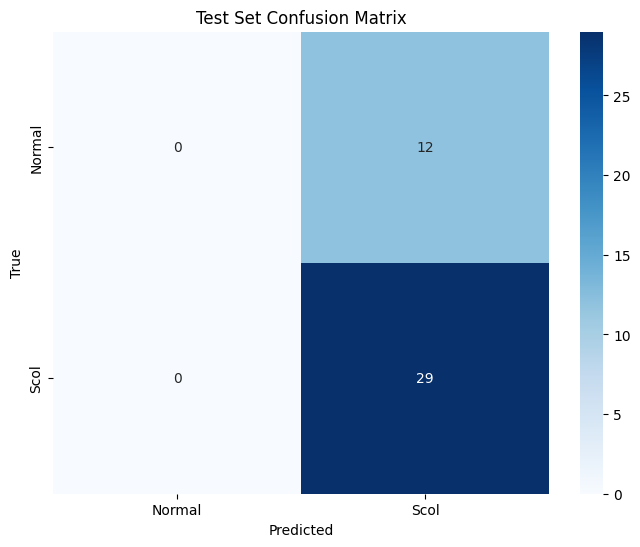

In [ ]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(test_labels, test_preds)
print("\nTest Set Confusion Matrix:")
print(cm)
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Normal', 'Scol']))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Scol'], yticklabels=['Normal', 'Scol'])
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
